In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F


In [ ]:
#数据集路径配置
data_dir =r"E:\github复现\resnet实现项目test\data\trait"
train_dir = data_dir + '\\train'  #注意使用双斜杠不然就是转义字符
val_dir=data_dir+'\\val' 
test_dir = data_dir + '\\test'  #我的数据集命名是这样的

In [ ]:
# 打印出数据集路径 来查看是否正确
print(train_dir)
print(test_dir)
print(val_dir)

In [ ]:
#选取一张指定的图片测试路径是否错误
from PIL import Image
import os
#拼接train_dir和相对路径来读取照片 ，并显示在记事本格中
image_path = os.path.join(train_dir, 'cat', 'cat.0.jpg')
image = Image.open(image_path)
plt.imshow(image)

In [ ]:
#声明计算结果 方便调试
mean=[0.4883, 0.4551, 0.4170]
std=[0.2294, 0.2250, 0.2252]
#imagenet的均值和方差  我们可以用来对比一下
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

代码可以计算 train 目录下所有图片（包括 cat 和 dog）的均值和标准差。ImageFolder 会将 train 目录下的所有图片加载为一个数据集，而你的代码会遍历整个数据集，计算所有图片的像素值总和、平方和以及像素总数，最终得到整个数据集的均值和标准差。

图像分类任务中，通常是对整个训练集（包括所有类别）计算均值和标准差，而不是对每个类别分别计算。这是因为归一化的目的是将输入数据的分布调整为均值为 0、标准差为 1 的标准正态分布，以便模型更容易训练。因此，你应该使用整个 train 数据集的均值和标准差。

ImageFolder它会自动将每个子目录（如 cat 和 dog）视为一个类别，并为每张图片分配对应的类别标签。ImageFolder 返回的数据集是一个可迭代对象，每个元素是一个元组 (image, label)，其中 image 是经过 transform 处理后的图像张量，label 是对应的类别索引

In [ ]:
#数据增强和预处理
#训练集增强
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
#验证集处理 不需要随机裁剪和翻转
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

用户使用了相同的`transforms`来处理训练集和测试集，这可能不合适。通常，训练集会应用更多的数据增强（如随机裁剪、水平翻转等），而测试集仅需要简单的中心裁剪和归一化。当前的`transforms`可能没有对训练集进行足够的数据增强，导致模型泛化能力不足。

In [ ]:
#我们可以试着自己查看图片增强之后的某张图片 查看效果 
#不过通过对比imagenet和我们自己的数据能看出基本是正确的

In [47]:

train_dataset = torchvision.datasets.ImageFolder(
    root=train_dir, 
    transform=train_transforms
)


val_dataset = torchvision.datasets.ImageFolder(
    root=val_dir,
    transform=test_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    root=test_dir, 
    transform=test_transforms
)


train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=4
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32, 
    shuffle=False, 
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=4
)


#查看数据集大小和类别
class_names = train_dataset.classes
#在此出顺便声明一下class_nams 方便后面实例化模型
print(f"\nClass names: { train_dataset.classes}")
print(f"\nClass names: { val_dataset.classes}")
print(f"\nClass names: { test_dataset.classes}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Train dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}\n")
#查看某一批次经过预处理后的图片效果
dataiter = iter(train_loader)
try:
    images, labels = dataiter.__next__()
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
except StopIteration:
    print("No more data in the iterator.")

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


Class nmes: ['cat', 'dog']
Train dataset size: 25000
Val dataset size: 782
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])

这里我们能看到其实每一个批次的图片是经过预处理后得到的随机的224*224大小的图片，并且标签也是对应的
也就是说 我有25000张图片 我每一批次送32张，在同一个epoch里我就要送25000/32=781.25~782次
那么我的图像预处理时其实是对这25000张图片的每一张进行随机裁剪翻转等等，
我的epoch周期有很多，所以在不同epoch时，同一张图片的变换是不一样的.从而增强了模型的泛化能力


In [48]:
class BasicBlock(nn.Module):
    """残差块实现，包含两个卷积层"""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1,
                           stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))  # 第一个卷积层 + BN + ReLU
        out = self.bn2(self.conv2(out))  # 第二个卷积层 + BN
        out += self.shortcut(x)  # 残差连接
        out = torch.relu(out)  # 最终激活函数
        return out

In [49]:
class ResNet(nn.Module):
    """ResNet主体架构"""
    def __init__(self, block, num_blocks, num_classes=2):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
   

In [51]:
#实例化模型
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=len(class_names)).to(device)

In [52]:
# 3. 训练准备
from torch.optim import lr_scheduler  # 添加这行导入语
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,betas=(0.9, 0.999))
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=25,eta_min=1e-6)  
# Tmax是从0.001到最小学习率所经过的epoch数，每次cos_lr_scheduler.step()，lr就会改变，直到Tmax次step()后学习率变成设定的最小值
#TODO Tmax自己算,总共25个epoch，每个epoch有len(train_loader)个batch,所以你可以每个epoch更新一次lr，Tmax = 25就行了，最后衰减到1e-6

Loaded best model weights for further training.
Epoch [1/10] | Batch [100/625] | Loss: 0.3525 | Acc: 83.94%
Epoch [1/10] | Batch [200/625] | Loss: 0.3501 | Acc: 83.94%
Epoch [1/10] | Batch [300/625] | Loss: 0.3478 | Acc: 84.27%
Epoch [1/10] | Batch [400/625] | Loss: 0.3486 | Acc: 84.21%
Epoch [1/10] | Batch [500/625] | Loss: 0.3443 | Acc: 84.44%
Epoch [1/10] | Batch [600/625] | Loss: 0.3434 | Acc: 84.37%
Saved best model with acc 89.44%

Epoch 1 Summary:
Train Loss: 0.3428 | Train Acc: 84.42%
Val Loss: 0.2447 | Val Acc: 89.44%

Epoch [2/10] | Batch [100/625] | Loss: 0.3204 | Acc: 86.03%
Epoch [2/10] | Batch [200/625] | Loss: 0.3258 | Acc: 85.41%
Epoch [2/10] | Batch [300/625] | Loss: 0.3198 | Acc: 85.72%
Epoch [2/10] | Batch [400/625] | Loss: 0.3202 | Acc: 85.66%
Epoch [2/10] | Batch [500/625] | Loss: 0.3165 | Acc: 85.81%
Epoch [2/10] | Batch [600/625] | Loss: 0.3153 | Acc: 85.88%
Saved best model with acc 91.88%

Epoch 2 Summary:
Train Loss: 0.3146 | Train Acc: 85.91%
Val Loss: 0.1877

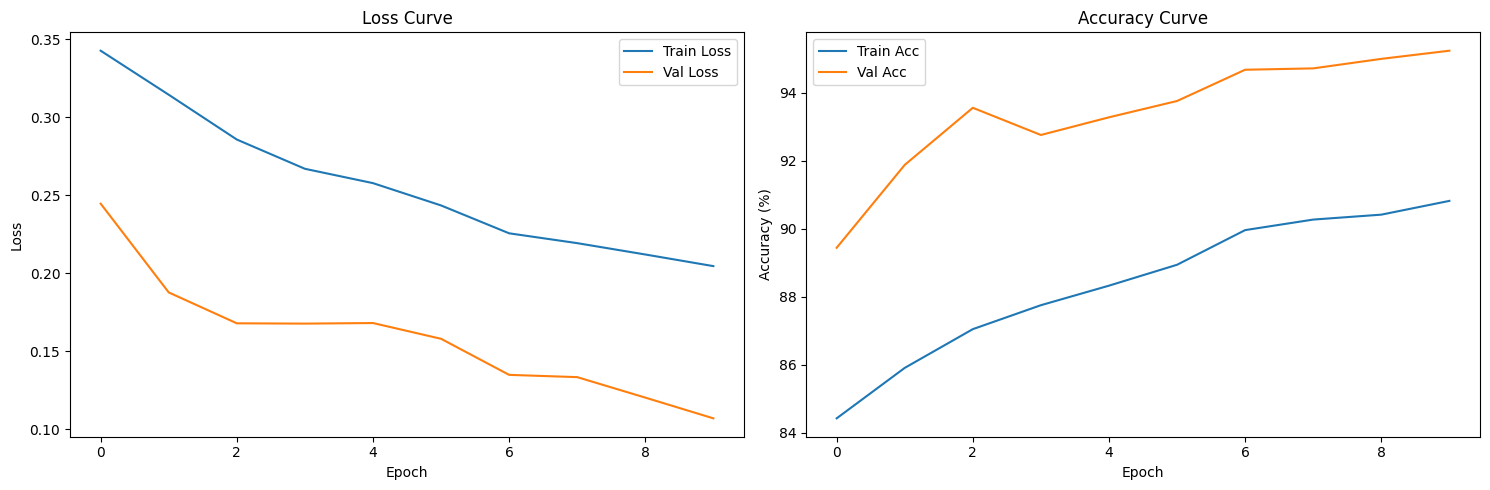

In [56]:
# 改进后的训练函数
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_acc = 0.0  # 新增最佳准确率跟踪
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'batch_loss': []
    }
# 加载最优权重
    if os.path.exists('best_model.pth'):  # 检查权重文件是否存在
        model.load_state_dict(torch.load('best_model.pth'))
        print("Loaded best model weights for further training.")
    else:
        print("No best model weights found. Starting training from scratch.")
        
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # 训练阶段
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 统计信息
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # 每100批次打印信息
            if (batch_idx + 1) % 100 == 0:
                batch_loss = running_loss / (batch_idx + 1)
                batch_acc = 100. * correct / total
                print(f'Epoch [{epoch+1}/{num_epochs}] | '
                      f'Batch [{batch_idx+1}/{len(train_loader)}] | '
                      f'Loss: {batch_loss:.4f} | '
                      f'Acc: {batch_acc:.2f}%')
                history['batch_loss'].append(batch_loss)

        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        # 记录历史数据
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        val_loss = val_loss / len(test_loader)
        val_acc = 100. * val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
          # 保存最佳模型
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')  # 正确保存位置
            print(f"Saved best model with acc {val_acc:.2f}%")

        # 打印epoch总结
        print(f'\nEpoch {epoch+1} Summary:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n')
        
        # 更新学习率
        scheduler.step()
       
   
    return history

# 可视化函数
def plot_history(history):
    plt.figure(figsize=(15, 5))
    # 损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 训练并可视化
history = train_model(model, criterion, optimizer, scheduler, num_epochs=10)
plot_history(history)


In [54]:
# 测试模块
# 最终测试（使用独立测试集）
# 测试模型
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_loss = test_loss / len(test_loader)
test_acc = 100. * test_correct / test_total
print(f'Final Test Results: Loss: {test_loss:.4f} | Acc: {test_acc:.2f}%')

Final Test Results: Loss: 0.2704 | Acc: 88.00%


Predicted class: dog


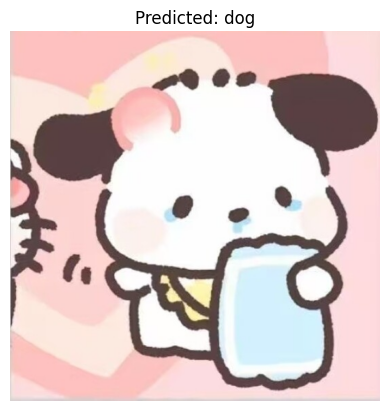

In [79]:
# 单张图片预测
def predict_image(image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = test_transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        prediction = output.argmax(dim=1).item()
    return class_names[prediction]

# 示例
image_path = r"C:\Users\WangZiqiang\OneDrive\桌面\测试\10.jpg"
predicted_class = predict_image(image_path)
print("Predicted class:", predicted_class)

# 可视化预测结果
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f'Predicted: {predicted_class}')
plt.show()